In [1]:
!pip install gymnasium -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.1/952.1 kB 14.1 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.29.0
    Uninstalling gymnasium-0.29.0:
      Successfully uninstalled gymnasium-0.29.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.2.3 which is incompatible.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.2.3 which is incompatible.


# Обучение агента играть в Snake

## 1. Описание задачи
**Игра Snake**: Классическая аркадная игра, где змейка перемещается по сетке, собирает еду и растет в длину. <br>
Агент должен научиться:
- Эффективно находить и собирать еду
- Избегать столконовений со стенами и собственным телом
- Максимизировать длину змейки и времени выживания

### Пространство состояний 
Представим в векторном формате:
- Позиция головы: $(x, y)$
- Позиция еды: $(x_f, y_f)$
- Направление движения: one-hot вектор [UP, DOWN, LEFT, RIGHT]
- Опасности: бинарные флаги для препятствий в каждом направлении
- Observation space: Box(low=-inf, high=inf, shape=(n,)), n = 2+2+4+4 = 12

> Змейка не может развернутся на 180°. Вместо сокращения пространства действий сделаем обработку недопустимого, противоположного действия.

### Функция награды
$R_t = \begin{cases}
+10 & \text{если съедена еда} \\
-10 & \text{если столкновение (смерть)} \\
-0.01 & \text{за каждый шаг (штраф за время)}
\end{cases}
$

In [2]:
import os
import time
import joblib
import random
import warnings
from tabulate import tabulate
from collections import deque, defaultdict
from typing import Tuple, Dict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
from gymnasium.utils.env_checker import check_env
from gymnasium.wrappers import RecordVideo

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from moviepy.editor import ImageSequenceClip
from IPython.display import clear_output

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
A

In [3]:
def plot_rewards_and_loss(rewards_history, losses_history, steps_history, 
                          algorithm_name="", window=50, update_freq=10):
    """Отрисовка графиков реварда и лосса с обновлением в реальном времени"""
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
    
    episodes = np.arange(len(rewards_history))

    # === Верхний график: Reward vs Episodes ===
    ax1.plot(episodes, rewards_history, alpha=0.3, color='blue', label='Raw Reward', linewidth=0.5)
    if len(rewards_history) >= window:
        smoothed = np.convolve(rewards_history, np.ones(window)/window, mode='valid')
        smoothed_episodes = np.arange(window-1, len(rewards_history))
        ax1.plot(smoothed_episodes, smoothed, color='red', label=f'Smoothed (window={window})', linewidth=2)
    
    ax1.axhline(y=5, color='yellow', linestyle='--', label='Min result (5)', alpha=0.7)
    ax1.axhline(y=10, color='green', linestyle='--', label='Good result (10+)', alpha=0.7)
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'{algorithm_name} - Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # === Нижний график: Log10(Loss) vs Total Steps ===
    if len(losses_history) > 0:
        losses = np.array(losses_history)
        valid_mask = losses > 0
        cumulative_steps = np.cumsum(steps_history[:len(losses[valid_mask])])
        ax2.plot(cumulative_steps, np.log10(losses[valid_mask]), color='purple', alpha=0.7, linewidth=1)
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Log10(Loss)')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No loss data yet', transform=ax2.transAxes, 
                 ha='center', va='center', fontsize=12, color='gray')
        ax2.set_xlabel('Total Environment Steps')
        ax2.set_ylabel('Loss')

    plt.tight_layout()
    plt.show()

## 2. Реализация среды

In [4]:
class SnakeEnv(gym.Env):
    def __init__(self, grid_size: int = 10, max_steps: int = 1_000, render_mode=None):
        super().__init__()
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(0, 1, shape=(13,), dtype=np.float32)
        self.moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # up, right, down, left
        self.render_mode = render_mode
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.steps = 0
        self.score = 0
        self.total_reward = 0.0
        c = self.grid_size // 2
        self.snake = [(c, c)]
        self.dir = 1  # start moving right
        self._place_food()
        return self._get_obs(), {} # obs, info

    def _place_food(self):
        while True:
            self.food = tuple(self.np_random.integers(0, self.grid_size, size=2))
            if self.food not in self.snake:
                break

    def _in_bounds(self, pos):
        x, y = pos
        return 0 <= x < self.grid_size and 0 <= y < self.grid_size

    def _is_collision(self, pos):
        return not self._in_bounds(pos) or pos in self.snake

    def _get_danger(self):
        head = self.snake[0]
        danger = []
        for dx, dy in self.moves:
            danger.append(float(self._is_collision((head[0] + dx, head[1] + dy))))
        return np.array(danger, dtype=np.float32)

    def _get_obs(self):
        scale = self.grid_size - 1
        hx, hy = self.snake[0]
        fx, fy = self.food
        head_norm = np.array([hx, hy], dtype=np.float32) / scale
        food_norm = np.array([fx, fy], dtype=np.float32) / scale
        dir_onehot = np.eye(4, dtype=np.float32)[self.dir]
        danger = self._get_danger()
        manhattan = (abs(hx - fx) + abs(hy - fy)) / (2 * scale) # normalized manhattan distance to food
        return np.concatenate([head_norm, food_norm, dir_onehot, danger, [manhattan]]).astype(np.float32)

    def step(self, action: int):
        # prevent 180-degree turns
        if action == (self.dir^2):
            action = self.dir
        self.dir = action

        dx, dy = self.moves[self.dir]
        head = self.snake[0]
        new_head = (head[0] + dx, head[1] + dy)
        self.steps += 1

        if self._is_collision(new_head):
            reward, terminated = -10.0, True
        else:
            self.snake.insert(0, new_head)
            if new_head == self.food:
                self.score += 1
                reward = 10.0
                self._place_food()
            else:
                self.snake.pop()
                reward = -0.01
            terminated = False

        self.total_reward += reward
        filled = len(self.snake) == self.grid_size ** 2
        truncated = (self.steps >= self.max_steps) or filled # truncate if max steps reached or grid is completely filled
        info = {"score": self.score, "length": len(self.snake)}
        return self._get_obs(), reward, terminated, truncated, info

    def render(self, mode="human"):
        if mode is None:
            mode = self.render_mode  # fallback на установленный режим
            
        if mode == "human":
            EMPTY = "⬜" # "."
            HEAD = "🟢"  # "H"
            BODY = "🟩"  # "B"
            FOOD = "🍎"  # "F"

            clear_output(wait=True)
            grid = [[EMPTY for _ in range(self.grid_size)] for _ in range(self.grid_size)]
            for i, (x, y) in enumerate(self.snake):
                grid[y][x] = HEAD if i == 0 else BODY
            fx, fy = self.food
            grid[fy][fx] = FOOD
            print('\n'.join(' '.join(row) for row in grid))
            print(f"Length: {len(self.snake)} | Steps: {self.steps} | Reward: {self.total_reward:.2f}")

        elif mode == "rgb_array":
            cell_size = 30
            img_width = self.grid_size * cell_size
            img_height = self.grid_size * cell_size + 40  # + место для текста
            
            img = Image.new("RGB", (img_width, img_height), color=(255, 255, 255)) 
            draw = ImageDraw.Draw(img)

            colors = {
                'empty': (240, 240, 240),
                'head': (0, 200, 0),
                'body': (0, 150, 0),
                'food': (255, 0, 0),
                'border': (180, 180, 180),
                'text': (0, 0, 0)
            }

            # Рисуем сетку
            for y in range(self.grid_size):
                for x in range(self.grid_size):
                    rect = (
                        x * cell_size,
                        y * cell_size,
                        (x + 1) * cell_size,
                        (y + 1) * cell_size
                    )
                    # Фон ячейки
                    draw.rectangle(rect, fill=colors['empty'], outline=colors['border'])

                    # Змея и еда
                    if (x, y) == self.snake[0]:
                        draw.rectangle(rect, fill=colors['head'], outline=colors['border'])
                    elif (x, y) in self.snake:
                        draw.rectangle(rect, fill=colors['body'], outline=colors['border'])
                    elif (x, y) == self.food:
                        draw.rectangle(rect, fill=colors['food'], outline=colors['border'])

            # Текстовая информация
            try:
                font = ImageFont.truetype("arial.ttf", 16)
            except IOError:
                font = ImageFont.load_default()

            text = f"Length: {len(self.snake)} | Steps: {self.steps} | Reward: {self.total_reward:.2f}"
            draw.text((10, img_height - 30), text, fill=colors['text'], font=font)

            # Конвертируем в numpy array
            return np.array(img)

        else:
            raise ValueError(f"Unsupported render mode: {mode}")

In [5]:
# Test environment functionality
env = SnakeEnv(grid_size=10, max_steps=200)
obs, info = env.reset(seed=42)
env.render()

for _ in range(100):
    action = env.action_space.sample()  # random action
    time.sleep(0.2)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        print(f"Episode finished: {info}")
        break

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🟢 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
🍎 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Length: 1 | Steps: 25 | Reward: -10.24
Episode finished: {'score': 0, 'length': 1}


In [6]:
# Check env compliance with Gym
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    check_env(SnakeEnv())

## 3. Реализация алгоритмов

In [7]:
class QNetwork(nn.Module):
    def __init__(self, obs_dim=13, action_dim=4, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.stack(states),
            np.array(actions),
            np.array(rewards),
            np.stack(next_states),
            np.array(dones)
        )

    def __len__(self):
        return len(self.buffer)

class DQN:
    def __init__(self, env, lr=1e-3, gamma=0.99, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_net = QNetwork().to(self.device)
        self.target_net = QNetwork().to(self.device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer()
        
        self.gamma = gamma
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

        self.update_target()

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def act(self, state, greedy=False):
        if not greedy and random.random() < self.eps:
            return self.env.action_space.sample()
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q_values = self.q_net(state)
        return q_values.argmax().item()

    def learn(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)

        current_q = self.q_net(states).gather(1, actions).squeeze()
        next_q = self.target_net(next_states).max(1)[0].detach()
        target_q = rewards + self.gamma * next_q * (1 - dones)
        
        loss = F.mse_loss(target_q, current_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.eps = max(self.eps_end, self.eps * self.eps_decay)
        
        return loss.item()

class QLearning:
    def __init__(self, env, lr=0.1, gamma=0.99, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        self.env = env
        self.lr = lr
        self.gamma = gamma
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.q_table = {}

    def _discretize_obs(self, obs):
        """
        Преобразует непрерывное наблюдение (13D) в компактное дискретное состояние.
        Формат obs: [hx, hy, fx, fy, dir0,dir1,dir2,dir3, d_up,d_right,d_down,d_left, manhattan]
        """
        # Опасность (биты 8–11)
        danger = tuple(int(x > 0.5) for x in obs[8:12])

        # Направление еды: из относительных координат (биты 0–3)
        head_x, head_y = obs[0], obs[1]
        food_x, food_y = obs[2], obs[3]
        dx = np.sign(food_x - head_x)
        dy = np.sign(food_y - head_y)
        food_dir = (int(dx + 1), int(dy + 1))  # -1→0, 0→1, +1→2 → (0..2, 0..2)

        # Направление движения (биты 4–7): one-hot → индекс
        move_dir = int(np.argmax(obs[4:8]))

        return danger + food_dir + (move_dir,)

    def act(self, obs, greedy=False):
        state = self._discretize_obs(obs)
        if not greedy and random.random() < self.eps:
            return self.env.action_space.sample()
        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.env.action_space.n)
        return np.argmax(self.q_table[state])

    def learn(self, obs, action, reward, next_obs, done):
        state = self._discretize_obs(obs)
        next_state = self._discretize_obs(next_obs)

        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.env.action_space.n)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.env.action_space.n)

        current_q = self.q_table[state][action]
        next_max_q = np.max(self.q_table[next_state]) if not done else 0.0
        target = reward + self.gamma * next_max_q
        td_error = (target - current_q)
        loss = td_error ** 2
        self.q_table[state][action] += self.lr * td_error

        self.eps = max(self.eps_end, self.eps * self.eps_decay)
        return loss


class SARSA(QLearning):
    def learn(self, obs, action, reward, next_obs, next_action, done):
        state = self._discretize_obs(obs)
        next_state = self._discretize_obs(next_obs)

        if state not in self.q_table:
            self.q_table[state] = np.zeros(self.env.action_space.n)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(self.env.action_space.n)

        current_q = self.q_table[state][action]
        next_q = self.q_table[next_state][next_action] if not done else 0.0
        target = reward + self.gamma * next_q
        td_error = (target - current_q)
        loss = td_error ** 2
        self.q_table[state][action] += self.lr * td_error

        self.eps = max(self.eps_end, self.eps * self.eps_decay)
        return loss

def train_agent(
    env,
    agent,
    episodes=2_000,
    target_update_freq=100,
    batch_size=64,
    save_last_path="last.pth",
    save_best_path="best.pth",
    save_best=True,
    eval_freq=100,
    eval_window=50
):
    episode_rewards = []
    episode_lengths = []
    episode_losses = []
    best_avg_reward = -float('inf')

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        step_count = 0
        loss_sum = 0.0
        loss_count = 0

        if isinstance(agent, SARSA):
            action = agent.act(state)
        else:
            action = None

        while True:
            if not isinstance(agent, SARSA):
                action = agent.act(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Обучение
            if hasattr(agent, 'replay_buffer'):  # DQN
                agent.replay_buffer.push(state, action, reward, next_state, done)
                loss = agent.learn(batch_size)

            elif isinstance(agent, SARSA):  # SARSA
                if not done:
                    next_action = agent.act(next_state)
                    loss = agent.learn(state, action, reward, next_state, next_action, done)
                    action = next_action
                else:
                    # Последнее обновление без next_action
                    loss = agent.learn(state, action, reward, next_state, None, done)

            else:  # Q-learning
                loss = agent.learn(state, action, reward, next_state, done)

            if loss is not None:
                loss_sum += loss
                loss_count += 1
            state = next_state
            total_reward += reward
            step_count += 1

            if done:
                break

        episode_rewards.append(total_reward)
        episode_lengths.append(step_count)
        episode_losses.append(loss_sum / loss_count if loss_count > 0 else 0.0)

        # Обновление целевой сети (DQN)
        if hasattr(agent, 'update_target') and ep % target_update_freq == 0:
            agent.update_target()

        # Сохранение лучшей модели
        if save_best and (ep + 1) % eval_freq == 0 and len(episode_rewards) >= eval_window:
            current_avg_reward = np.mean(episode_rewards[-eval_window:])
            if current_avg_reward > best_avg_reward:
                best_avg_reward = current_avg_reward
                _save_agent(agent, save_best_path)

        # Визуализация
        if (ep + 1) % 10 == 0 or ep == episodes - 1:
            plot_rewards_and_loss(
                rewards_history=episode_rewards,
                losses_history=episode_losses,
                steps_history=episode_lengths,
                algorithm_name=agent.__class__.__name__,
                window=50
            )

    # Сохранение ПОСЛЕДНЕЙ модели
    _save_agent(agent, save_last_path)

    return episode_rewards, episode_lengths, episode_losses

def _save_agent(agent, path):
    """Универсальное сохранение: модель (PyTorch) или q_table (skops)."""
    if hasattr(agent, 'q_net'):
        torch.save(agent.q_net.state_dict(), path)
    else:
        joblib.dump(agent, path.replace('.pth', '.jbl'))

def evaluate_agent(env, agent, episodes=1_000):
    foods = []
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        while True:
            action = agent.act(obs, greedy=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
            if done:
                foods.append(info["score"])
                rewards.append(total_reward)
                break
                
    return np.mean(foods), np.std(foods), np.mean(rewards), np.std(rewards)

## 4. Обучение алгоритмов

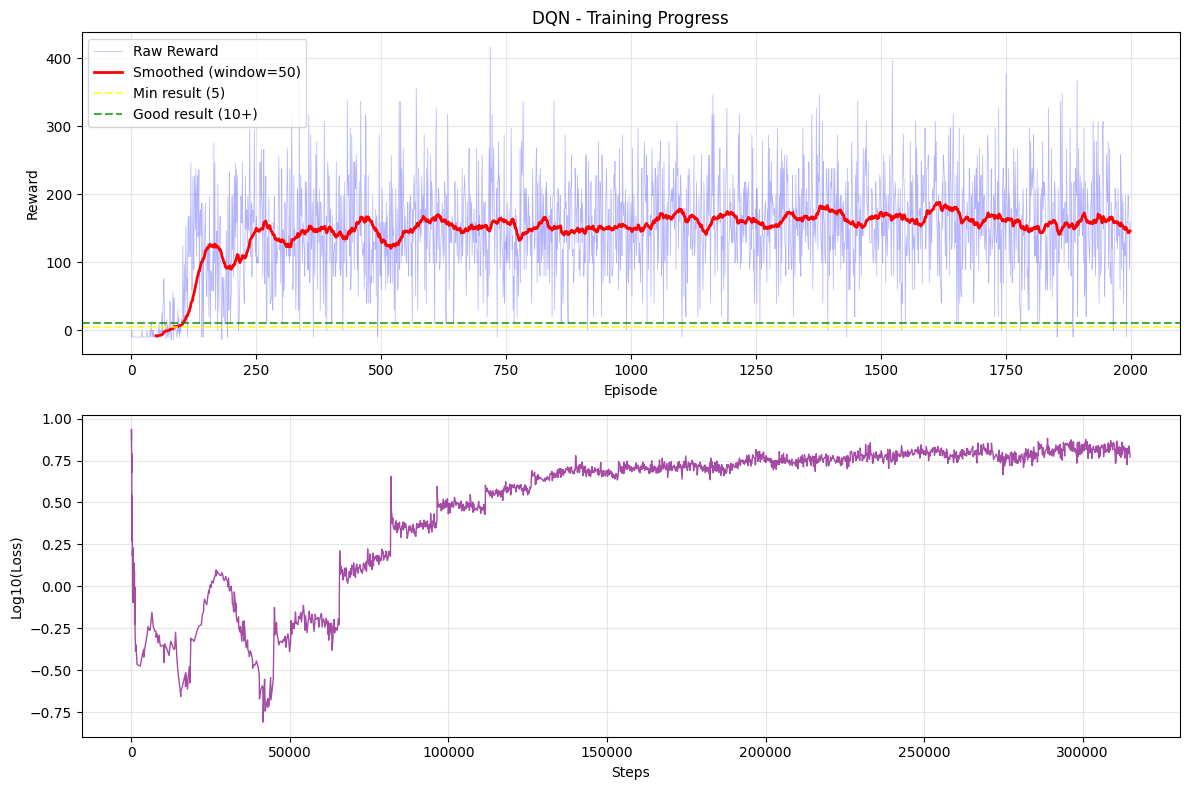

CPU times: user 26min 34s, sys: 7.58 s, total: 26min 41s
Wall time: 14min 4s


In [8]:
%%time
env = SnakeEnv(grid_size=10, max_steps=1_000)
dqn_agent = DQN(env)
dqn_scores = train_agent(env, dqn_agent, episodes=2_000, save_best=False, save_last_path="dqn.pth")

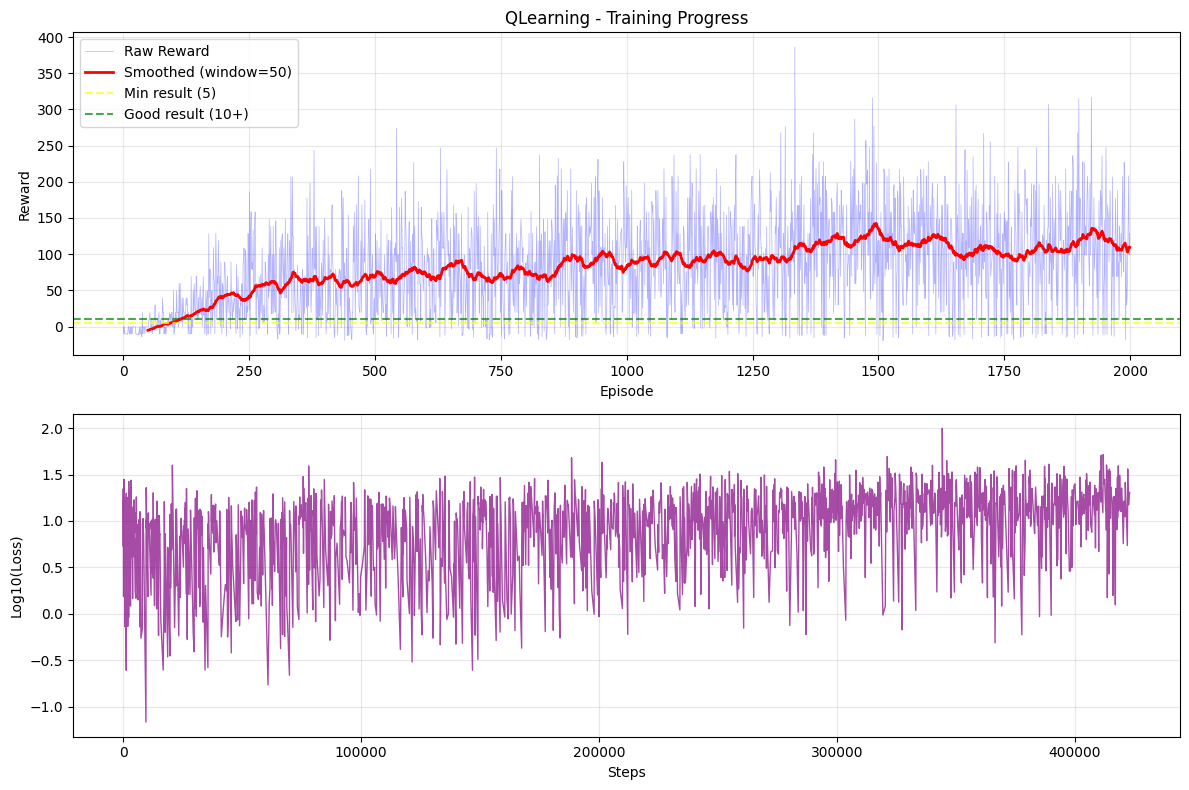

CPU times: user 1min 58s, sys: 2.12 s, total: 2min
Wall time: 2min


In [9]:
%%time
env = SnakeEnv(grid_size=10, max_steps=1_000)
q_agent = QLearning(env)
q_scores = train_agent(env, q_agent, episodes=2_000, save_best=False, save_last_path="q.pth")

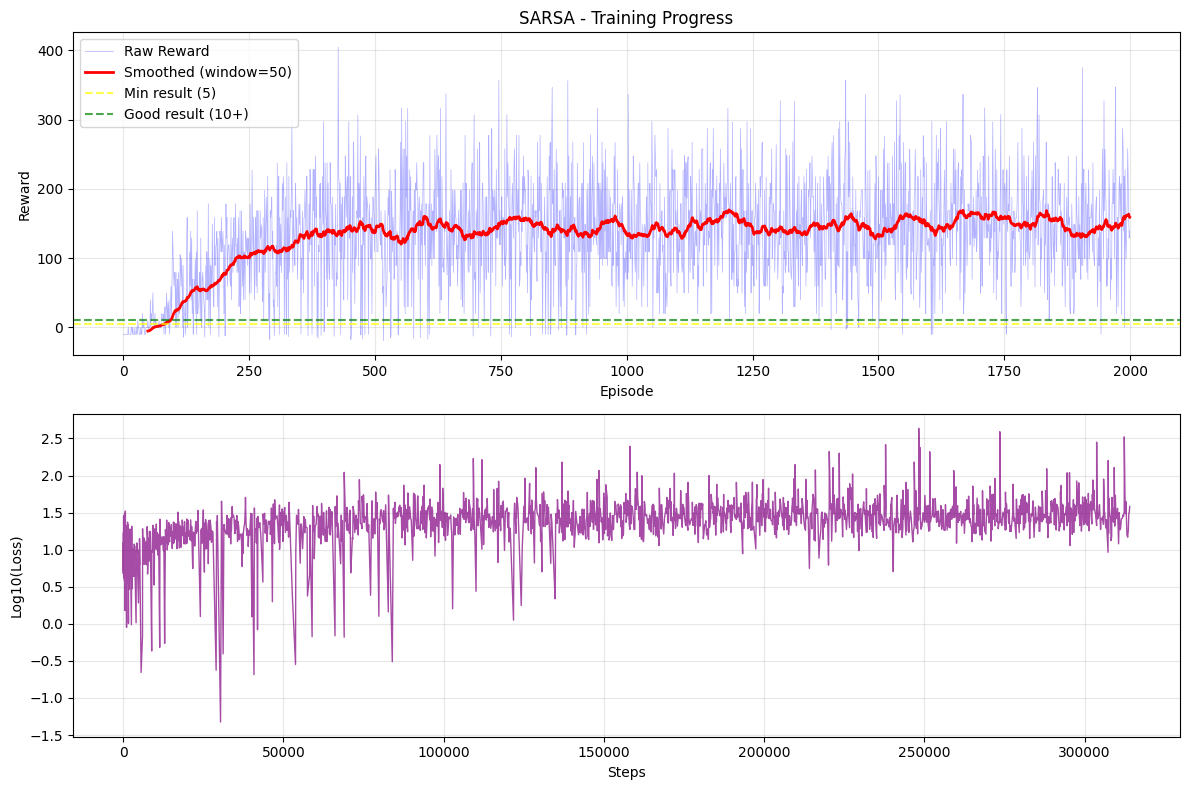

CPU times: user 1min 44s, sys: 2.02 s, total: 1min 46s
Wall time: 1min 46s


In [10]:
%%time
env = SnakeEnv(grid_size=10, max_steps=1_000)
sarsa_agent = SARSA(env)
sarsa_scores = train_agent(env, sarsa_agent, episodes=2_000, save_best=False, save_last_path="sarsa.pth")

In [11]:
%%time
table_data = []
env = SnakeEnv(grid_size=10, max_steps=1_000)
q_algos = [dqn_agent, q_agent, sarsa_agent]
for algo in q_algos:
    mean_foods, std_foods, mean_reward, std_reward = evaluate_agent(env, sarsa_agent, episodes=10)
    table_data.append(
        [algo.__class__.__name__, f"{mean_foods:.3f}", f"{std_foods:.3f}", 
         f"{mean_reward:.3f}", f"{std_reward:.3f}"])

headers = ["Algorithm", "Mean foods", "Std foods", "Mean reward", "Std reward"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+-------------+--------------+-------------+---------------+--------------+
| Algorithm   |   Mean foods |   Std foods |   Mean reward |   Std reward |
+=============+==============+=============+===============+==============+
| DQN         |         18   |       8.112 |       168.472 |       80.251 |
+-------------+--------------+-------------+---------------+--------------+
| QLearning   |         20   |       6.148 |       188.178 |       60.806 |
+-------------+--------------+-------------+---------------+--------------+
| SARSA       |         17.6 |       5.783 |       164.478 |       57.028 |
+-------------+--------------+-------------+---------------+--------------+
CPU times: user 311 ms, sys: 5.99 ms, total: 317 ms
Wall time: 314 ms


In [12]:
# Можно проверить работу
env = SnakeEnv(grid_size=10, max_steps=1_000)
obs, info = env.reset(seed=42)
env.render()
total_reward = 0

for _ in range(100):
    action = sarsa_agent.act(obs, greedy=True)
    time.sleep(0.2)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    env.render()
    if terminated or truncated:
        print(f"Episode finished: {info}")
        break

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🟩 🟩 🟩 🟩 ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🟩 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🟩 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🟩 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🟩 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🟩 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🟢 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
⬜ 🍎 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜
Length: 10 | Steps: 100 | Reward: 89.09


## 5. Запись видео работы

**Запись через `gym.RecordVideo`**
>```python
num_eval_episodes = 5
video_folder = "./snake_videos"
os.makedirs(video_folder, exist_ok=True)
env = SnakeEnv(grid_size=10, max_steps=1000, render_mode="rgb_array")  # rgb_array needed for video recording
env = RecordVideo(
    env,
    video_folder,
    name_prefix="dqn",
    fps=10,
    episode_trigger=lambda x: True # Record every episode
)
for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    episode_over = False
    while not episode_over:
        action = dqn_agent.act(obs, greedy=True)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_over = terminated or truncated
env.close()
```

In [13]:
def record_comparison_video(
    env_class,
    agents,
    episodes=5,
    max_steps_per_episode=1_000,
    save_path="comparison_agents.mp4",
    fps=10,
    padding=20,
    title_height=60,
    max_no_food_steps=100  # ← можно настроить
):
    all_frames = []

    for ep in range(episodes):
        envs = [env_class(grid_size=10, max_steps=max_steps_per_episode) for _ in range(3)]
        states = []
        dones = [False, False, False]
        no_food_steps = [0] * 3  # счётчик шагов без еды для каждого агента
        snake_lengths = []       # запомним начальную длину (обычно 1)

        for env in envs:
            s, _ = env.reset()
            states.append(s)
            snake_lengths.append(len(env.snake))  # начальная длина

        step = 0
        while not all(dones) and step < max_steps_per_episode:
            frames = []
            for env in envs:
                frame = env.render(mode="rgb_array")
                frames.append(frame)

            h, w, c = frames[0].shape
            total_w = 3 * w + 2 * padding
            combined = np.zeros((h + title_height, total_w, c), dtype=np.uint8)
            combined.fill(255)

            x_offset = 0
            for i, frame in enumerate(frames):
                combined[title_height:, x_offset:x_offset+w] = frame
                x_offset += w + padding

            combined_pil = Image.fromarray(combined)
            draw = ImageDraw.Draw(combined_pil)

            try:
                font = ImageFont.truetype("arial.ttf", 20)
                big_font = ImageFont.truetype("arial.ttf", 28)
            except IOError:
                font = ImageFont.load_default()
                big_font = ImageFont.load_default()

            episode_text = f"Episode {ep + 1}"
            bbox = draw.textbbox((0, 0), episode_text, font=big_font)
            text_width = bbox[2] - bbox[0]
            x_center = (total_w - text_width) // 2
            draw.text((x_center, 10), episode_text, fill=(0, 0, 0), font=big_font)

            for i, agent in enumerate(agents):
                name = agent.__class__.__name__
                x = i * (w + padding) + w // 2 - len(name) * 6
                y = 10 + title_height // 2 - 10
                draw.text((x, y), name, fill=(0, 0, 0), font=font)

            all_frames.append(np.array(combined_pil))

            actions = []
            for i, (agent, env) in enumerate(zip(agents, envs)):
                if dones[i]:
                    actions.append(None)
                    continue

                action = agent.act(states[i], greedy=True)
                actions.append(action)

            new_states = []
            for i, (env, action) in enumerate(zip(envs, actions)):
                if dones[i] or action is None:
                    new_states.append(states[i])
                    continue

                next_s, r, term, trunc, info = env.step(action)
                done = term or trunc

                if len(env.snake) > snake_lengths[i]:
                    no_food_steps[i] = 0
                    snake_lengths[i] = len(env.snake)
                else:
                    no_food_steps[i] += 1
                    if no_food_steps[i] >= max_no_food_steps:
                        done = True  # принудительно завершаем

                dones[i] = done
                new_states.append(next_s)

            states = new_states
            step += 1

        for env in envs:
            env.close()

        # Пауза в конце
        if all_frames:
            last_frame = all_frames[-1]
            for _ in range(fps * 2):
                all_frames.append(last_frame)

    clip = ImageSequenceClip(all_frames, fps=fps)
    clip.write_videofile(save_path, codec="libx264", audio=False)

In [16]:
!rm snake_agents_comparison.mp4

In [17]:
agents = [dqn_agent, q_agent, sarsa_agent]
record_comparison_video(
    env_class=SnakeEnv,
    agents=agents,
    episodes=5,
    save_path="snake_agents_comparison.mp4"
)

Moviepy - Building video snake_agents_comparison.mp4.
Moviepy - Writing video snake_agents_comparison.mp4



Moviepy - Done !
Moviepy - video ready snake_agents_comparison.mp4
